<a href="https://colab.research.google.com/github/sharmin133/Rice-Leaf/blob/main/Resnet101%2Bprewitt%2Bclahe_final_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras import layers, models
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.applications import ResNet101

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=25

In [ ]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/Final Thesis/Feature Extraction/Prewitt edge detection/CHAHE+prewitt",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7471 files belonging to 5 classes.


In [ ]:
class_names= dataset.class_names
print(class_names)
len(dataset)

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro', '_Healthy']


234

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[2 1 3 1 0 2 3 3 4 1 4 2 4 1 2 1 1 2 0 2 3 0 4 0 3 1 0 1 1 2 1 2]


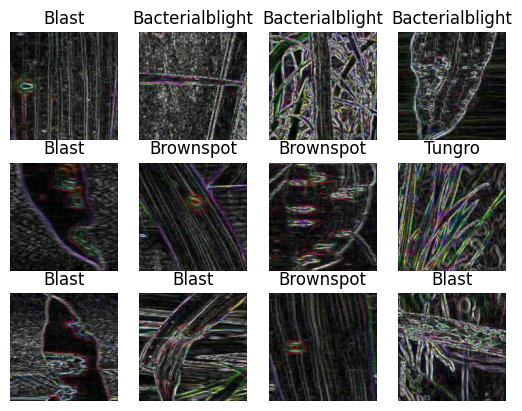

In [ ]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split +  val_split+test_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
train_ds, val_ds,test_ds= get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

163
23
48


In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
n_classes = len(class_names)
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

model =Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

171446536/171446536 [==============================] - 5s 0us/step


In [ ]:
base_model.trainable=False

In [ ]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 68349829 (260.73 MB)
Trainable params: 25691653 (98.01 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________


In [ ]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
163/163 [==============================] - 364s 152ms/step - loss: 5.0707 - accuracy: 0.8631 - val_loss: 0.1721 - val_accuracy: 0.9777
Epoch 2/25
163/163 [==============================] - 11s 66ms/step - loss: 0.1899 - accuracy: 0.9792 - val_loss: 0.2132 - val_accuracy: 0.9805
Epoch 3/25
163/163 [==============================] - 11s 66ms/step - loss: 0.1255 - accuracy: 0.9865 - val_loss: 0.0549 - val_accuracy: 0.9930
Epoch 4/25
163/163 [==============================] - 11s 66ms/step - loss: 0.1127 - accuracy: 0.9860 - val_loss: 0.1008 - val_accuracy: 0.9889
Epoch 5/25
163/163 [==============================] - 11s 67ms/step - loss: 0.0338 - accuracy: 0.9937 - val_loss: 0.3919 - val_accuracy: 0.9736
Epoch 6/25
163/163 [==============================] - 11s 66ms/step - loss: 0.1511 - accuracy: 0.9869 - val_loss: 0.0629 - val_accuracy: 0.9930
Epoch 7/25
163/163 [==============================] - 11s 66ms/step - loss: 0.2105 - accuracy: 0.9850 - val_loss: 0.5792 - val_accurac

In [ ]:
scores = model.evaluate(test_ds)

48/48 [==============================] - 15s 61ms/step - loss: 0.4949 - accuracy: 0.9870


In [ ]:
scores

[0.4948532283306122, 0.9869791865348816]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

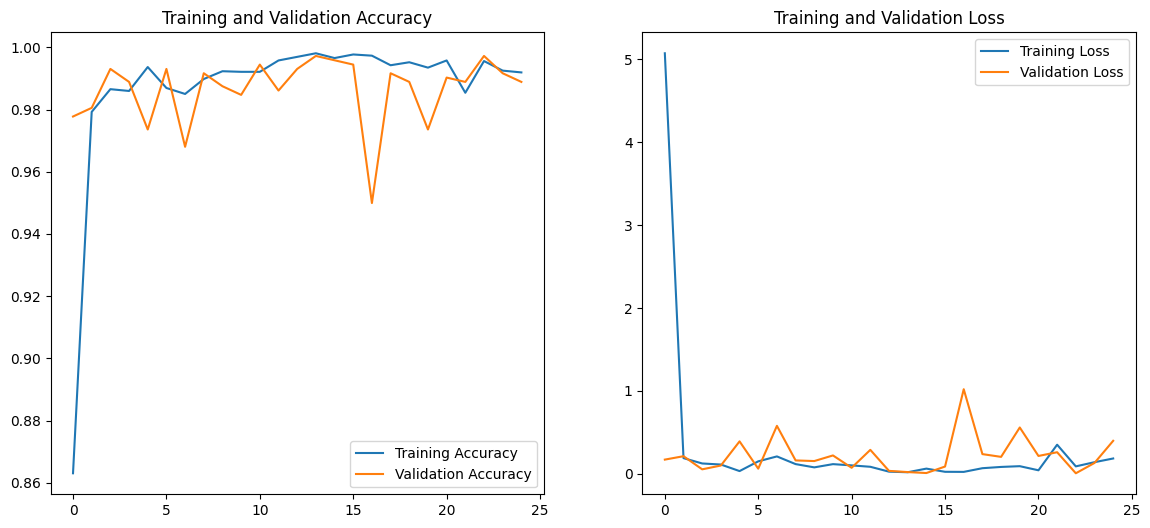

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tungro
1/1 [==============================] - 2s 2s/step
predicted label: Tungro


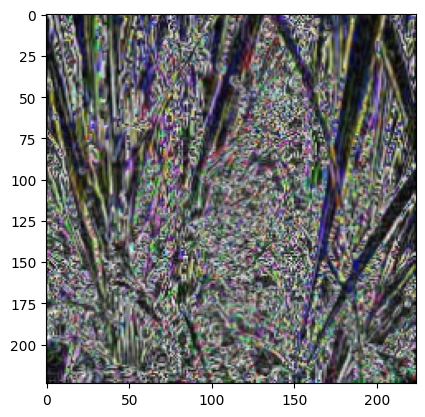

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

48/48 [==============================] - 3s 55ms/step


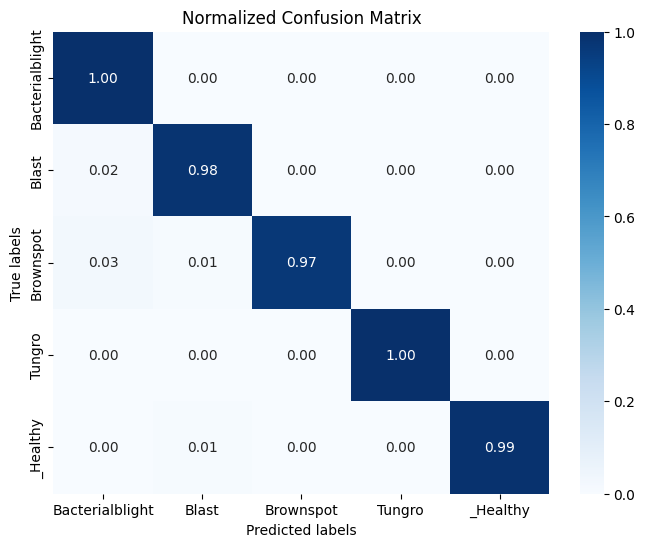

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
predicted_labels = np.argmax(model.predict(test_images), axis=-1)
cm = confusion_matrix(test_labels, predicted_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
target_names = class_names
report = classification_report(test_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

Bacterialblight       0.96      1.00      0.98       315
          Blast       0.98      0.98      0.98       286
      Brownspot       1.00      0.97      0.98       347
         Tungro       1.00      1.00      1.00       271
       _Healthy       1.00      0.99      1.00       317

       accuracy                           0.99      1536
      macro avg       0.99      0.99      0.99      1536
   weighted avg       0.99      0.99      0.99      1536

